In [1]:
%matplotlib inline
import astropy.io.fits as pyfits
import numpy as np
from astropy.utils.data import get_pkg_data_filename
import subprocess as sp
import scipy.ndimage as sci_nd
import glob
import matplotlib.pyplot as mpl
from astropy.table import Table
import sys
import os
from astropy.io import ascii


In [2]:
#from utils on Bruno's github

def select_object_map(xc,yc,segmap,pixscale,radius):
    r"""Filters the segmentation mask of the object by setting all regions
    outside the given radius (in arcseconds) to 0 in the output segmentation
    mask.
    Parameters
    ----------
    xc : float
        the horizontal coordinate (in pixel) of the object center
    yc : float
        the vertical coordinate (in pixel) of the object center
    segmap: int, array
        A binary image array flagging all pixels to be considered for the
        computation. It uses all pixels with non-zero values.
    pixscale : float
        The scale to convert between pixel and arcseconds (given in arcsec/pix).
        If one wants to compute everything in pixel coordinates simply set the
        pixscale to one.
    radius : float
        The distance to consider above which all detected objects are discarded.
        Note that it is only required that a region has at least one pixel at a
        distance smaller than radius to be included in the filtered segmentation
        mask.
    Returns
    -------
    new_map : int, array
        A binary array with all regions containing at least one pixel at a
        distance smaller than the given radius.
    References
    ----------
    Examples
    --------
    """
    Dmat,d=distance_matrix(xc,yc,segmap)
    s_values = np.unique(segmap[Dmat<np.sqrt(2)*radius/pixscale])
    new_map = segmap.copy()
    for s in s_values:
        if s==0:
            continue
        new_map[new_map==s]=-1
    new_map[new_map>0]=0
    return -new_map

def select_object_map_connected(xc,yc,image,segmap,pixscale,radius=0.5):
    r"""Selects a single connected region on the segmentation mask that contains
    the brightest pixel inside the given radius (in arcseconds).
    Parameters
    ----------
    xc : float
        the horizontal coordinate (in pixel) of the object center
    yc : float
        the vertical coordinate (in pixel) of the object center
    img : float, array
        The image array containing the data for which to select the region.
    segmap: int, array
        A binary image array flagging all pixels to be considered for the
        computation. It uses all pixels with non-zero values.
    pixscale : float
        The scale to convert between pixel and arcseconds (given in arcsec/pix).
        If one wants to compute everything in pixel coordinates simply set the
        pixscale to one.
    radius : float
        The distance to consider above which all detected objects are discarded.
        Note that it is only required that a region has at least one pixel at a
        distance smaller than radius to be included in the filtered segmentation
        mask.
    Returns
    -------
    new_map : int, array
        A binary array with the connected region containing the brightest pixel
        at a distance smaller than the given radius.
    References
    ----------
    Examples
    --------
    """
    Regions,Nregions = sci_nd.label(segmap)
#    A= np.array([np.size(Regions[Regions==n]) for n in range(1,Nregions+1)])
    try:
        central_region = image.copy()
        #print('test1')
        Dmat,d=distance_matrix(xc,yc,segmap)
        #print('test2')
        ##print('Dmat shape:',np.shape(Dmat),'lenght Dmat:',len(Dmat),'type Dmat:', type(Dmat))#,'Dmat:',Dmat)
       ## print('central region type:',type(central_region),'central region shape:',np.shape(central_region))
        central_region[Dmat>(radius/pixscale)]=0.0
        #print('test3')
        central_region*=segmap
        #print('test4')
        fmax = np.where(central_region == np.amax(central_region))
        #print('test5')
        n = Regions[fmax]
##        F= np.array([np.amax(image[Regions==n]) for n in range(1,Nregions+1)])
##        n = np.argmax(F)+1
        #print('test6')
        Regions[Regions!=n]=0
        #print('test7')
        Regions[Regions>0]=1

    except ValueError as err:
        ## IN CASE OF NON-DETECTIONS returns empty segmentation map
        print(err)
        pass

    # import matplotlib.pyplot as mpl
    # nFig,nAx = mpl.subplots(1,3)
    # nAx[0].imshow(segmap,cmap='rainbow')
    # nAx[0].plot([xc],[yc],'wx',markersize=20,mew=2)
    # nAx[1].imshow(central_region,cmap='rainbow')
    # nAx[1].plot([xc],[yc],'wx',markersize=20,mew=2)
    # nAx[2].imshow(Regions,cmap='YlGnBu_r')
    # nAx[2].plot([xc],[yc],'rx',markersize=20,mew=2)
    # mpl.show()
    return Regions


def get_center_coords(imgname,ra,dec,hsize=1,verify_limits=True):
    r""" Computes the x,y coordinates of a ra,dec position in a given image.
    Parameters
    ----------
    imgname : string
        The name of the FITS image to use as reference frame
    ra : float
        the right ascension coordinate
    dec: float
        the declination coordinate
    hsize : int, optional
        if given, checks if the computed coordinates are at a distance greater
        than hsize from the image border.
    verify_limits : bool, optional
        if True, verifies the distance of the coordinates to the image border.
    Returns
    -------
    (xc,yc) : tuple, float
        A tuple with the x and y pixel-coordinates corresponing to the given
        sky coordinates using the input image as reference frame.
    References
    ----------
    Examples
    --------
    """
    hdr=pyfits.getheader(imgname)

    return get_center_coords_hdr(hdr,ra,dec,hsize=1,verify_limits=verify_limits)

def compute_ellipse_distmat(img,xc,yc,q=1.00,ang=0.00,overSampling = 1):
    r"""Compute a matrix with dimensions of the image where in each pixel we
    have the distance to the center xc,yc.
    Parameters
    ----------
    img : float, array
        The image array containing the data for which to compute the distance
        matrix.
    xc : float
        the horizontal coordinate (in pixel) of the ellipse center
    yc : float
        the vertical coordinate (in pixel) of the ellipse center
    q : float, optional
        the axis ratio of the ellipse. If not given, computes the distance
        assuming a circular geometry.
    ang : float, optional
        the position angle (in degrees) of the ellipse. If not given, an angle
        of zero degrees is assumed.
    Returns
    -------
    dmat : float, array
        A 2D array of the same shape as the input image where each pixel encodes
        its distance to the input center coordinates and the given geometry.
    References
    ----------
    Examples
    --------
    """
    ang_rad = np.radians(ang)
   ## print("image shape:",img.shape)
    X,Y = np.meshgrid(np.arange(img.shape[1]*overSampling),np.arange(img.shape[0]*overSampling))
   ## print('x & y shapes:',X.shape, Y.shape)
    rX=(X-xc*overSampling)/overSampling*np.cos(ang_rad)-(Y-yc*overSampling)/overSampling*np.sin(ang_rad)
    rY=(X-xc*overSampling)/overSampling*np.sin(ang_rad)+(Y-yc*overSampling)/overSampling*np.cos(ang_rad)
    dmat = np.sqrt(rX*rX+(1/(q*q))*rY*rY)
    return dmat

def distance_matrix(xc,yc,img):
    r"""Compute a matrix with circular distances and a sorted np.array with
    unique distance values from each pixel position to xc,yc.
    Parameters
    ----------
    xc : float
        the horizontal coordinate (in pixel) of the ellipse center
    yc : float
        the vertical coordinate (in pixel) of the ellipse center
    img : float, array
        The image array containing the data for which to compute the distance
        matrix.
    Returns
    -------
    Dmat : float, array
        A 2D array of the same shape as the input image where each pixel encodes
        its distance to the input center coordinates assuming circular geometry.
    dists : float, array
        a sorted array with unique distance values from the 2D distance matrix.
    References
    ----------
    See also
    ----------
    compute_ellipse_distmat
    Examples
    --------
    """
    Dmat= compute_ellipse_distmat(img,xc,yc)
    ##print("DMat shape:",np.shape(Dmat))
    dists=np.sort(np.unique(Dmat))
    return Dmat, dists


In [3]:
#from galfit on Bruno's github


def get_fixpars_default():
    r""" Returns the default dictionary containing the information on whether
    or not to fix any parameter of the fit. By default, all parameters are
    not fixed.
    Parameters
    ----------
    Returns
    -------
    fixpars : dict
        A dictionary for each of the sersic parameters setting the fix/free key.
    References
    ----------
    Examples
    --------
    """
    return {'x':1,'y':1,'m':1,'re':1,'n':1,'q':1,'pa':1,'sky':1}



def write_object(model,x,y,m,re,n,ba,pa,num,fixpars=None):
    r""" Returns a string object containing a general description for a galaxy
    profile model in GALFIT, with the input parameters as first guesses.
    Parameters
    ----------
    model : str
    Returns
    -------
    References
    ----------
    Examples
    --------
    """
    if fixpars is None:
        fixpars=get_fixpars_default()

    objString = ""
    objString += "#Object number: %i\n"%(num)
    objString += " 0) %s             # Object type\n"%(model)
    objString += " 1) %6.4f %6.4f  %i %i    # position x, y        [pixel]\n"%(x,y,fixpars['x'],fixpars['y'])
    objString += " 3) %4.4f      %i       # total magnitude\n"%(m,fixpars['m'])
    objString += " 4) %4.4f       %i       #     R_e              [Pixels]\n"%(re,fixpars['re'])
    objString += " 5) %4.4f       %i       # Sersic exponent (deVauc=4, expdisk=1)\n"%(n,fixpars['n'])
    objString += " 9) %4.4f       %i       # axis ratio (b/a)   \n"%(ba,fixpars['q'])
    objString += "10) %4.4f       %i       # position angle (PA)  [Degrees: Up=0, Left=90]\n"%(pa,fixpars['pa'])
    objString += " Z) 0                  #  Skip this model in output image?  (yes=1, no=0)\n"
    objString += " \n"
    return objString


def input_file(f,modelsString,magzpt,sky,x_range,y_range,sconvbox,pixscale,imgname='input.fits',outname="output.fits",psfname='none',maskname="none",signame='none',fixpars=None):
    r""" Writes an input galfit file with the provided parameters.
    Parameters
    ----------
    f : file pointer
        Python file pointer to be written
    modelsString : str
        A single string containing the starting parameters of the models to be
        used. Model strings can be generated by the write_object function.
    magzpt : float
        Magnitude zeropoint of the image data. Needed for correct model
        magnitudes.
    sky : float
        Initial value for sky background (assumed to be constant)
    x_range : tuple, int
        X-axis boundaries to be used in image fitting (useful to fit a subset
        of a larger image).
    y_range : tuple, int
        Same as z_range, but for y-axis boundaries.
    sconvbox : int
        Size of the convolution box to be applied to the model image (should be
        at least the size of the PSF image).
    pixscale : float
        Pixel scale (in arcsecond/pixel) of the input image data
    imgname : str, optional
        Name of the image with the input data (default - input.fits)
    outname : str, optional
        Name of the output image block to be created by GALFIT
        (default - output.fits)
    psfname : str, optional
        Name of the psf fits file, to be used for model convolution
        (default - none, no psf used)
    maskname : str, optional
        Name of the mask file to be used in the fit. It mask bad pixel values
        and others (e.g. neighbor objects) that are ignored by the fitting
        algorithm (default - none, no mask used).
    signame : str, optional
        Error image corresponding to the input data.
        (default - none, sigma image created internally).
    fixpars : dict
        Dictionary which controls if parameters are fixed or not for the fit.
        This is used here to control wether the sky background is fixed or a
        free parameter for the fit.
    Returns
    -------
        None
        It writes to the file "f" and returns nothing.
    References
    ----------
    Examples
    --------
    """
    if fixpars is None:
        fixpars=get_fixpars_default()

    assert len(x_range)==len(y_range)==2,"x_range,y_range must have two elements"
    assert x_range[1]>x_range[0],"x_range must be sorted in ascendent order"
    assert y_range[1]>y_range[0],"y_range must be sorted in ascendent order"

    f.write("================================================================================\n")
    f.write("# IMAGE and GALFIT CONTROL PARAMETERS\n")
    f.write("A) %s         # Input data image (FITS file)\n"%imgname)
    f.write("B) %s        # Output data image block\n"%outname)
    f.write("C) %s                # Sigma image name (made from data if blank or 'none' \n"%signame)
    f.write("D) %s         # Input PSF image and (optional) diffusion kernel\n"%psfname)
    f.write("E) 1                   # PSF fine sampling factor relative to data \n")
    f.write("F) %s                # Bad pixel mask (FITS image or ASCII coord list)\n"%maskname)
    f.write("G) none                # File with parameter constraints (ASCII file) \n")
    f.write("H) %i    %i   %i    %i # Image region to fit (xmin xmax ymin ymax)\n"%(x_range[0],x_range[1],y_range[0],y_range[1]))
    f.write("I) %i    %i          # Size of the convolution box (x y)\n"%(sconvbox,sconvbox))
    f.write("J) %7.5f             # Magnitude photometric zeropoint \n"%magzpt)
    f.write("K) %.3f %.3f        # Plate scale (dx dy)   [arcsec per pixel]\n"%(pixscale,pixscale))
    f.write("O) regular             # Display type (regular, curses, both)\n")
    f.write("P) 0                   # Options: 0=normal run; 1,2=make model/imgblock and quit\n")
    f.write("\n")
    f.write("# INITIAL FITTING PARAMETERS\n")
    f.write("#\n")
    f.write("#For object type, the allowed functions are:\n")
    f.write("#nuker, sersic, expdisk, devauc, king, psf, gaussian, moffat,\n")
    f.write("#ferrer, and sky.\n")
    f.write("#\n")
    f.write("#Hidden parameters will only appear when theyre specified:\n")
    f.write("#C0 (diskyness/boxyness),\n")
    f.write("#Fn (n=integer, Azimuthal Fourier Modes).\n")
    f.write("#R0-R10 (PA rotation, for creating spiral structures).\n")
    f.write("#\n")
    f.write("# ------------------------------------------------------------------------------\n")
    f.write("#  par)    par value(s)    fit toggle(s)   parameter description\n")
    f.write("# ------------------------------------------------------------------------------\n")
    f.write("\n")

    f.write(modelsString)

    f.write("# Object: Sky\n")
    f.write(" 0) sky                    #  object type\n")
    f.write(" 1) %7.4f      %i          #  sky background at center of fitting region [ADUs]\n"%(sky,fixpars['sky']))
    f.write(" 2) 0.0000      0          #  dsky/dx (sky gradient in x)\n")
    f.write(" 3) 0.0000      0          #  dsky/dy (sky gradient in y)\n")
    f.write(" Z) 0                      #  output option (0 = resid., 1 = Dont subtract)")
    f.close()
    return


In [4]:
#amended code

def select_object_segmap(segmap,index):
    Regions = np.zeros_like(segmap)
    if index not in segmap:
        raise ValueError('index not in segmentation map')
    Regions[segmap==index]=index
    return Regions

In [5]:
#to easily cycle thru all filters....PART ONE

def usingfilter(filtername):
    #filter = filtername
    detected_objs_file_table = ascii.read('/data1/rowland/testPSF_{}.cat'.format(filtername))
    image_file = pyfits.open('/data1/rowland/elgordo_{}.fits'.format(filtername))
    segmap_file = pyfits.open('/data1/rowland/segmaps_check/{}_check.fits'.format(filtername))
    data_perfilter = detected_objs_file_table, image_file, segmap_file, filtername
    return(data_perfilter)

In [6]:
#to easily cycle thru all filters....PART TWO


filters = ["F105W","F125W","F140W","F160W","F435W","F606W","F625W","775W","814W","F850LP","F105W_galfit_test_folder"]

#ONLY CHANGES NEEDED: FILTER HERE, ADJUST B1&B2 VALUES
############################################################################
data = usingfilter(filters[0])
############################################################################
print('Currently using this filter:',data[3])

Currently using this filter: F105W


In [7]:
#defing the chosen filters data to use throughout code below
detected_objs_file = data[0]
image_file = data[1]
segmap_file = data[2]
filtername = data[3]

# Starting to make parameters needed for GalFits input config file

In [8]:
#defing inputs
#Main Idea: Mask_name = segmentation_map - mask_map
#                       segmentation_maps = {filter}_check.fits files


#One Filter to start
#filters = {"F105W"}

#all detected objects in this filter
#detected_objs_file = ascii.read('/data1/rowland/testPSF_F105W.cat')



#these are what changes
# image_file = pyfits.open('/data1/rowland/elgordo_F105W.fits')
# segmap_file = pyfits.open('/data1/rowland/segmaps_check/F105W_check.fits')
# detected_objs_file = ascii.read('/data1/rowland/testPSF_F105W.cat')
# print('one;',type(image_file),'two:',type(segmap_file), 'three:',type(detected_objs_file))

### Subselecting detections from segmap

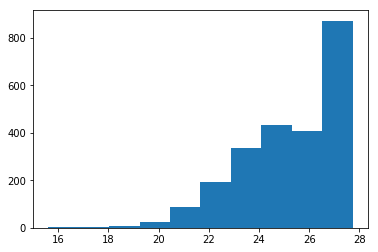

In [9]:
#test for where to put mag cut

mpl.hist(detected_objs_file['MAG_AUTO'])

mpl.show()

In [10]:
#subselecting detections for bright galaxies likely to be part of the cluster

#quick cut based on magnitudes to get brightest BUT theres stars in here!, need further cut
short_detections_intermediate = np.where(detected_objs_file['MAG_AUTO']<20)
short_detections_stillstarstho = detected_objs_file[short_detections_intermediate]
short_detections_stillstarstho

NUMBER,MAG_AUTO,KRON_RADIUS,ISOAREA_IMAGE,XPEAK_IMAGE,YPEAK_IMAGE,X_IMAGE,Y_IMAGE,A_IMAGE,THETA_IMAGE,MU_MAX,ELLIPTICITY,CLASS_STAR,FLUX_RADIUS
,mag,,pix2,pix,pix,pix,pix,pix,deg,mag / arcsec2,,,pix
int64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64
49,16.8159,3.5,2907,2069,687,2069.7666,686.6608,4.373,-1.29,15.7178,0.068,0.998,2.576
70,18.2507,3.5,6022,1667,842,1667.3851,842.0582,16.98,37.22,19.0108,0.527,0.921,9.893
236,19.873,4.81,3040,1545,1218,1545.1145,1218.0986,13.518,59.61,21.059,0.309,0.922,16.019
286,19.0743,3.5,964,2836,1258,2835.8049,1257.6709,3.552,-15.97,17.9312,0.079,0.975,2.516
413,18.509,3.64,6377,2023,1761,2022.579,1761.2362,18.282,42.21,20.0029,0.441,0.107,13.258
738,17.1776,3.5,2360,3043,2098,3043.8003,2097.4651,4.078,-7.54,15.7596,0.027,0.976,2.295
815,19.5938,3.5,1797,2039,2057,2039.0352,2056.7297,10.212,-21.72,19.837,0.524,0.87,6.32
859,19.7286,3.5,653,905,2091,905.2455,2091.0654,3.394,5.5,18.6888,0.175,0.958,2.545


RED line is B1, BLUE line is B2
Above red line are galaxies, between red & blue are stars


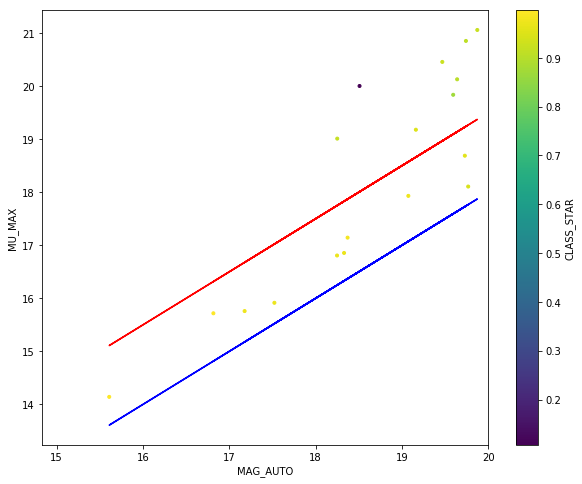

In [11]:
# seperating stars from galaxies in above list (using psf code tricks)

%matplotlib inline


####################################################################adjust as needed
B1 = .5 #red
B2 = 2 #blue
#######################################################################
print('RED line is B1, BLUE line is B2')
print('Above red line are galaxies, between red & blue are stars')

fig,ax = mpl.subplots(figsize=(10,8))
S = ax.scatter(short_detections_stillstarstho["MAG_AUTO"],short_detections_stillstarstho["MU_MAX"], \
               c =short_detections_stillstarstho["CLASS_STAR"], marker=".")
P2 = ax.plot(short_detections_stillstarstho["MAG_AUTO"],short_detections_stillstarstho["MAG_AUTO"]-B1,color='r')
P1 = ax.plot(short_detections_stillstarstho["MAG_AUTO"],short_detections_stillstarstho["MAG_AUTO"]-B2,color='b')
ax.set_xlim(0.95*min(short_detections_stillstarstho["MAG_AUTO"]),20)
ax.set_xlabel("MAG_AUTO")
ax.set_ylabel("MU_MAX")
CLB = mpl.colorbar(S,ax=ax)
CLB.set_label("CLASS_STAR")
mpl.show()


In [12]:
#only selecting the galaxies


galselection_intermediate1 = np.where(short_detections_stillstarstho["MU_MAX"] > (short_detections_stillstarstho["MAG_AUTO"]-B1)) 
selection_ofgalaxies = short_detections_stillstarstho[galselection_intermediate1]
print('selection of galaxies:')
selection_ofgalaxies #= selection_ofgalaxies.astype(np.int16) #goes from boolean to binary


selection of galaxies:


NUMBER,MAG_AUTO,KRON_RADIUS,ISOAREA_IMAGE,XPEAK_IMAGE,YPEAK_IMAGE,X_IMAGE,Y_IMAGE,A_IMAGE,THETA_IMAGE,MU_MAX,ELLIPTICITY,CLASS_STAR,FLUX_RADIUS
,mag,,pix2,pix,pix,pix,pix,pix,deg,mag / arcsec2,,,pix
int64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64
70,18.2507,3.5,6022,1667,842,1667.3851,842.0582,16.98,37.22,19.0108,0.527,0.921,9.893
236,19.873,4.81,3040,1545,1218,1545.1145,1218.0986,13.518,59.61,21.059,0.309,0.922,16.019
413,18.509,3.64,6377,2023,1761,2022.579,1761.2362,18.282,42.21,20.0029,0.441,0.107,13.258
815,19.5938,3.5,1797,2039,2057,2039.0352,2056.7297,10.212,-21.72,19.837,0.524,0.87,6.32
1429,19.4677,3.81,3475,2802,2912,2801.2766,2912.0305,13.029,28.94,20.4566,0.171,0.926,11.545
1450,19.7413,4.3,2001,2744,2911,2744.5549,2911.6685,11.035,52.73,20.8523,0.306,0.91,11.93
1506,19.6395,4.08,2239,3402,2972,3401.614,2972.3813,9.69,30.0,20.1289,0.21,0.906,8.879
1839,19.1615,3.5,2037,2692,3408,2692.2927,3408.125,11.211,-54.49,19.1786,0.61,0.952,6.201


In [13]:
#to select likely stars only

 

#keeping them tables
selection_intermediate1 = np.where(short_detections_stillstarstho["MU_MAX"] < (short_detections_stillstarstho["MAG_AUTO"]-B1)) 
selection_intermediate2 = short_detections_stillstarstho[selection_intermediate1]
selection_intermediate3 = np.where(selection_intermediate2["MU_MAX"] > (selection_intermediate2["MAG_AUTO"]-B2))
selection_ofstars = selection_intermediate2[selection_intermediate3]
print('selection of stars:')
selection_ofstars #= selection.astype(np.int16) #goes from boolean to binary


selection of stars:


NUMBER,MAG_AUTO,KRON_RADIUS,ISOAREA_IMAGE,XPEAK_IMAGE,YPEAK_IMAGE,X_IMAGE,Y_IMAGE,A_IMAGE,THETA_IMAGE,MU_MAX,ELLIPTICITY,CLASS_STAR,FLUX_RADIUS
,mag,,pix2,pix,pix,pix,pix,pix,deg,mag / arcsec2,,,pix
int64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64
49,16.8159,3.5,2907,2069,687,2069.7666,686.6608,4.373,-1.29,15.7178,0.068,0.998,2.576
286,19.0743,3.5,964,2836,1258,2835.8049,1257.6709,3.552,-15.97,17.9312,0.079,0.975,2.516
738,17.1776,3.5,2360,3043,2098,3043.8003,2097.4651,4.078,-7.54,15.7596,0.027,0.976,2.295
859,19.7286,3.5,653,905,2091,905.2455,2091.0654,3.394,5.5,18.6888,0.175,0.958,2.545
915,18.3705,3.5,1413,3375,2204,3374.6672,2204.7578,3.702,-34.61,17.144,0.042,0.981,2.326
1247,15.6094,3.5,6617,2561,2849,2560.8123,2848.3591,5.342,23.41,14.1421,0.053,0.998,2.197
1504,18.3298,3.5,823,2759,2899,2758.7595,2898.4578,3.39,-88.28,16.8555,0.15,0.972,2.184
1572,17.5226,3.5,2075,2610,3048,2609.9658,3047.9929,3.956,-17.46,15.9158,0.029,0.971,2.143


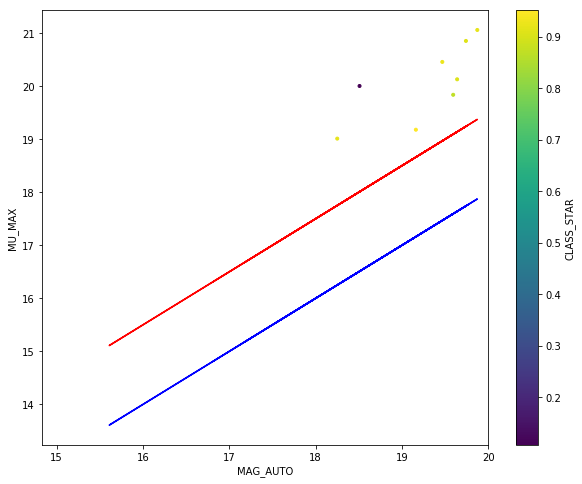

In [14]:
#checking if above cut was good enough

fig,ax = mpl.subplots(figsize=(10,8))
S = ax.scatter(selection_ofgalaxies["MAG_AUTO"],selection_ofgalaxies["MU_MAX"], \
               c =selection_ofgalaxies["CLASS_STAR"], marker=".")
P2 = ax.plot(short_detections_stillstarstho["MAG_AUTO"],short_detections_stillstarstho["MAG_AUTO"]-B1,color='r')
P1 = ax.plot(short_detections_stillstarstho["MAG_AUTO"],short_detections_stillstarstho["MAG_AUTO"]-B2,color='b')
ax.set_xlim(0.95*min(short_detections_stillstarstho["MAG_AUTO"]),20)
ax.set_xlabel("MAG_AUTO")
ax.set_ylabel("MU_MAX")
CLB = mpl.colorbar(S,ax=ax)
CLB.set_label("CLASS_STAR")
mpl.show()

In [15]:
#needed for cellS below

#change FILTER
#image_file = pyfits.open('/data1/rowland/elgordo_F105W.fits')

image_data = image_file[0].data #PARAMETER

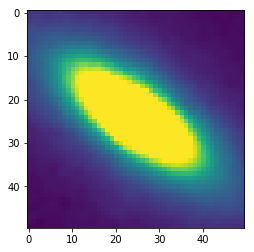

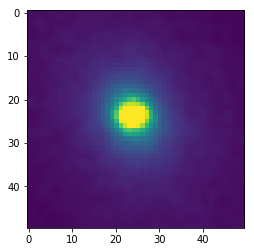

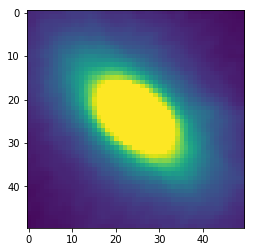

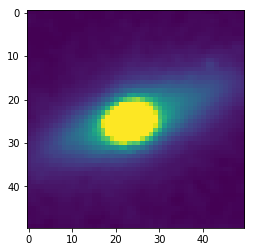

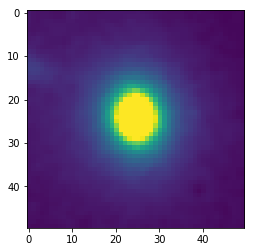

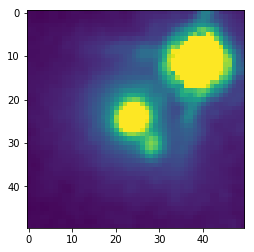

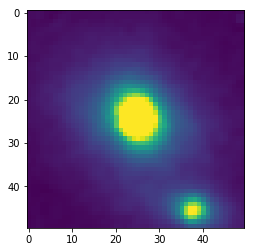

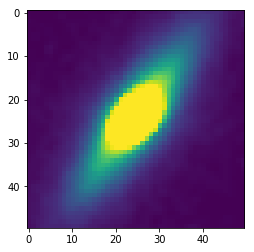

In [16]:
#verifying that stars  are stars & galaxies are galaxies

##uncomment if needed again, but plots use memory when rerunning

for image in selection_ofgalaxies:
    x = image['X_IMAGE'].astype(np.int)
    y = image['Y_IMAGE'].astype(np.int)
    width = 25
    fig = mpl.figure()
    mpl.imshow(image_data[y-width:y+width,x-width: x+width ], vmin=0,vmax=1)

## Creating mask of cluster's galaxies

In [17]:
#FULL RUN



#inputs defined
#segmap_file = pyfits.open('/data1/rowland/segmaps_check/F105W_check.fits')
segmap = segmap_file[0].data+0 #PARAMETER
collected_regions = []

#for reference
#image_file = pyfits.open('/data1/rowland/elgordo_F105W.fits')
#image_data = image_file[0].data #PARAMETER
#detected_objs_file = ascii.read('testPSF_F105W.cat')
#selection_ofgalaxies = [detected_objs_file(where MAGs<20) & not stars] #not really code


for detection in selection_ofgalaxies: #[1:3]:#[10:12]:
    xc = detection["X_IMAGE"] #in pix #PARAMETER
    yc = detection["Y_IMAGE"] #in pix #PARAMETER
    pixscale = 0.06 #PARAMETER
    index = detection['NUMBER']
    #radius=0.5 ##DEFAULT value for reference #PARAMETER
    each_region = select_object_segmap(segmap,index)
    collected_regions.append(each_region)
    print('SHOULD BE STARTING NEXT DETECTIONS CYCLE')  
    ##break #1
collected_regions = np.array(collected_regions)
print('collected_regions: type:',type(collected_regions), 'shape:',collected_regions.shape)    
final_regions = np.sum(collected_regions, axis=0) #COLLECTING ALL OUTPUTS TO ONE MASK
print('shape of final regions:',final_regions.shape)
#print(final)

SHOULD BE STARTING NEXT DETECTIONS CYCLE
SHOULD BE STARTING NEXT DETECTIONS CYCLE
SHOULD BE STARTING NEXT DETECTIONS CYCLE
SHOULD BE STARTING NEXT DETECTIONS CYCLE
SHOULD BE STARTING NEXT DETECTIONS CYCLE
SHOULD BE STARTING NEXT DETECTIONS CYCLE
SHOULD BE STARTING NEXT DETECTIONS CYCLE
SHOULD BE STARTING NEXT DETECTIONS CYCLE
collected_regions: type: <class 'numpy.ndarray'> shape: (8, 4824, 4538)
shape of final regions: (4824, 4538)


In [18]:
#checking output structures


#for reference
#filters = {"F105W"}
#detected_objs_file = ascii.read('/data1/rowland/testPSF_F105W.cat')
#image_file = pyfits.open('/data1/rowland/elgordo_F105W.fits')
#image_data = image_file[0].data #PARAMETER
#segmap_file = pyfits.open('/data1/rowland/segmaps_check/F105W_check.fits')
#segmap = segmap_file[0].data+0 #PARAMETER


print('shape of final regions:',final_regions.shape)
print('shape of one collected region:', collected_regions[0].shape)
print('shape of segmap:', segmap.shape)
print('shape of image data:',image_data.shape )
print('cat file is a table of the data in segmap:',detected_objs_file.info)

shape of final regions: (4824, 4538)
shape of one collected region: (4824, 4538)
shape of segmap: (4824, 4538)
shape of image data: (4824, 4538)
cat file is a table of the data in segmap: <Table length=2360>
     name      dtype       unit                            description                        
------------- ------- ------------- ----------------------------------------------------------
       NUMBER   int64               Running object number                                     
     MAG_AUTO float64           mag                    Kron-like elliptical aperture magnitude
  KRON_RADIUS float64               Kron apertures in units of A or B                         
ISOAREA_IMAGE   int64          pix2                    Isophotal area above Analysis threshold
  XPEAK_IMAGE   int64           pix                        x-coordinate of the brightest pixel
  YPEAK_IMAGE   int64           pix                        y-coordinate of the brightest pixel
      X_IMAGE float64           

## Creating Mask via subtraction

In [19]:

#creating mask
mask_file = segmap - final_regions #so the galaxies of the cluster have value=0

#setting values to be binary, all none cluster galaxy pixels are =1 (so galfit will ignore)
mask_file[np.where(mask_file > 0)]=1
#setting regions outside of observation to =1
mask_file[image_data==0]=1

##mask_file is now a fulll mask w

### verifying mask works

In [20]:
#getting tuples of coordinates for galaxies so can easily amend below code to zoom to each

object_coords = []
for detection in selection_ofgalaxies: #[1:3]:#[10:12]:
    xc = detection["X_IMAGE"] #in pix #PARAMETER
    yc = detection["Y_IMAGE"]
    coords = (xc,yc)
    object_coords.append(coords)
object_coords

[(1667.3851, 842.0582),
 (1545.1145, 1218.0986),
 (2022.579, 1761.2362),
 (2039.0352, 2056.7297),
 (2801.2766, 2912.0305),
 (2744.5549, 2911.6685),
 (3401.614, 2972.3813),
 (2692.2927, 3408.125)]

In [21]:
#not efficient but w/e


############################################################################################
#change based on number of galaxies selected above
############################################################################################
#for 1st detection
xc0 = object_coords[0][0]
yc0 = object_coords[0][1]
#for 2nd detection
xc1 = object_coords[1][0]
yc1 = object_coords[1][1]
#for 3rd detection
xc2 = object_coords[2][0]
yc2 = object_coords[2][1]
#for 4th detection
xc3 = object_coords[3][0]
yc3 = object_coords[3][1]
#for 5th detection
xc4 = object_coords[4][0]
yc4 = object_coords[4][1]
#for 6th detection
xc5 = object_coords[5][0]
yc5 = object_coords[5][1]
#for 7th detection
xc6 = object_coords[6][0]
yc6 = object_coords[6][1]
 #for 8th detection
xc7 = object_coords[7][0]
yc7 = object_coords[7][1]

print('fifth:',object_coords[4],'sixth:',object_coords[5])

fifth: (2801.2766, 2912.0305) sixth: (2744.5549, 2911.6685)


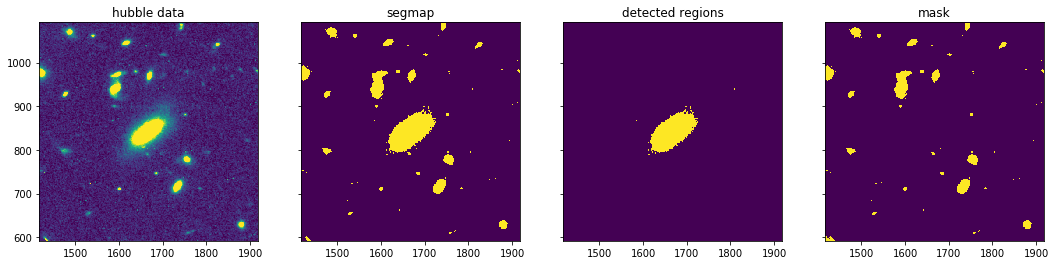

In [22]:
#this cell is alot to load, so only uncomment if need to see

 

#plotting all
fig, axis = mpl.subplots(1,4,figsize=(18,8),sharex=True,sharey=True)
axis[0].imshow(image_data,vmin = -0.01,vmax = 0.1)
axis[0].set_title('hubble data')
axis[1].imshow(segmap,vmin=0,vmax=1)
axis[1].set_title('segmap')
axis[2].imshow(final_regions,vmin=0, vmax=1)
axis[2].set_title('detected regions')
axis[3].imshow(mask_file,vmin=0,vmax=1)
axis[3].set_title('mask')



#amend above cell to zoom by detection
for ax in axis:
    #ax.plot(xc, yc, "+",ms=20,mew=3) #plots last run detected object
    
    w = 250
    #see above cell for meanings
    xc = xc0
    yc = yc0
    ax.set_xlim(xc-w,xc+w)
    ax.set_ylim(yc-w,yc+w)




# #below shows site of object that crashed galfit but mask/object look good, so idk...
# for ax in axis:
#     #ax.plot(xc, yc, "+",ms=20,mew=3) #plots last run detected object
    
#     w = 250
#     ax.set_xlim(xc-w,xc+w)
#     ax.set_ylim(yc-w,yc+w)


In [23]:

# %matplotlib notebook 

# #plotting
# mpl.imshow(mask_file,vmin=0,vmax=1)
# #axis[0].set_title('Original Mask')


# Dilated Final Galaxy Mask

In [24]:
 
%matplotlib inline 

#smoothing (ie increasing mask coverage to balance higher inital thresh when running SEx)
dilated_mask = sci_nd.binary_dilation(mask_file,structure=np.ones([3,3])).astype(np.int16)


# #plotting
# fig, axis = mpl.subplots(1,2,figsize=(18,8),sharex=True,sharey=True)
# axis[0].imshow(dilated_mask,vmin = -0.01,vmax = 0.1)
# axis[0].set_title('Dilated mask')
# axis[1].imshow(mask_file,vmin=0,vmax=1)
# axis[1].set_title('Original Mask')

In [25]:
#%matplotlib notebook 

#mpl.imshow(dilated_mask,vmin = -0.01,vmax = 0.1)


In [26]:
#saving files for a config run of galfit later

#saving mask as a fits file
#pyfits.writeto('/data1/rowland/masks/dilated_mask_F105W.fits',dilated_mask,overwrite=True)
#pyfits.writeto('/data1/rowland/masks/undilated_mask_F105W.fits',mask_file,overwrite=True)

pyfits.writeto('/data1/rowland/{}/dilated_mask.fits'.format(filtername),dilated_mask,overwrite=True)
pyfits.writeto('/data1/rowland/{}/undilated_mask.fits'.format(filtername),mask_file,overwrite=True)